In [ ]:
%matplotlib inline


Running NiBetaSeries
====================

This example runs through a basic call of NiBetaSeries using
the commandline entry point ``nibs``.
While this example is using python, typically ``nibs`` will be
called directly on the commandline.


Import all the necessary packages
=================================



In [1]:
import tempfile  # make a temporary directory for files
import os  # interact with the filesystem
import urllib.request  # grad data from internet
import tarfile  # extract files from tar
from subprocess import Popen, PIPE, STDOUT  # enable calling commandline

import matplotlib.pyplot as plt  # manipulate figures
import seaborn as sns  # display results
import pandas as pd   # manipulate tabular data

Download relevant data from ds000164 (and Atlas Files)
======================================================
The subject data came from `openneuro <https://openneuro.org/datasets/ds000164/versions/00001/>`_
:cite:`n-Verstynen2014`.
The atlas data came from a `recently published parcellation <https://www.ncbi.nlm.nih.gov/pubmed/28981612>`_
in a publically accessible github repository.



In [3]:
# atlas github repo for reference:
"""https://github.com/ThomasYeoLab/CBIG/raw/master/stable_projects/\
brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/"""
data_dir = tempfile.mkdtemp()
print('Our working directory: {}'.format(data_dir))

# download the tar data
url = "https://www.dropbox.com/s/qoqbiya1ou7vi78/ds000164-test_v1.tar.gz?dl=1"
tar_file = os.path.join(data_dir, "ds000164.tar.gz")
u = urllib.request.urlopen(url)
data = u.read()
u.close()

# write tar data to file
with open(tar_file, "wb") as f:
    f.write(data)

# extract the data
tar = tarfile.open(tar_file, mode='r|gz')
tar.extractall(path=data_dir)

os.remove(tar_file)

Our working directory: /var/folders/4j/sjbx9bj16538h292gjdpvrt00000gp/T/tmphix8omqk


Display the minimal dataset necessary to run nibs
=================================================



In [4]:
# https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))


list_files(data_dir)

tmphix8omqk/
    ds000164/
        CHANGES
        dataset_description.json
        README
        T1w.json
        task-stroop_bold.json
        task-stroop_events.json
        derivatives/
            data/
                Schaefer2018_100Parcels_7Networks_order.txt
                Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
            fmriprep/
                sub-001/
                    func/
                        sub-001_task-stroop_bold_confounds.tsv
                        sub-001_task-stroop_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz
                        sub-001_task-stroop_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
        sub-001/
            anat/
                sub-001_T1w.nii.gz
            func/
                sub-001_task-stroop_bold.nii.gz
                sub-001_task-stroop_events.tsv


Manipulate events file so it satifies assumptions
=================================================
1. the correct column has 1's and 0's corresponding to correct and incorrect,
respectively.
2. the condition column is renamed to trial_type
nibs currently depends on the "correct" column being binary
and the "trial_type" column to contain the trial types of interest.



read the file
-------------



In [5]:
events_file = os.path.join(data_dir,
                           "ds000164",
                           "sub-001",
                           "func",
                           "sub-001_task-stroop_events.tsv")
events_df = pd.read_csv(events_file, sep='\t', na_values="n/a")
print(events_df.head())

    onset  duration correct  condition  response_time
0   0.342         1       Y    neutral          1.186
1   3.345         1       Y  congruent          0.667
2  12.346         1       Y  congruent          0.614
3  15.349         1       Y    neutral          0.696
4  18.350         1       Y    neutral          0.752


replace condition with trial_type
---------------------------------



In [6]:
events_df.rename({"condition": "trial_type"}, axis='columns', inplace=True)
print(events_df.head())

    onset  duration correct trial_type  response_time
0   0.342         1       Y    neutral          1.186
1   3.345         1       Y  congruent          0.667
2  12.346         1       Y  congruent          0.614
3  15.349         1       Y    neutral          0.696
4  18.350         1       Y    neutral          0.752


save the file
-------------



In [7]:
events_df.to_csv(events_file, sep="\t", na_rep="n/a", index=False)

Manipulate the region order file
================================
There are several adjustments to the atlas file that need to be completed
before we can pass it into nibs.
Importantly, the relevant column names **MUST** be named "index" and "regions".
"index" refers to which integer within the file corresponds to which region
in the atlas nifti file.
"regions" refers the name of each region in the atlas nifti file.



read the atlas file
-------------------



In [8]:
atlas_txt = os.path.join(data_dir,
                         "ds000164",
                         "derivatives",
                         "data",
                         "Schaefer2018_100Parcels_7Networks_order.txt")
atlas_df = pd.read_csv(atlas_txt, sep="\t", header=None)
print(atlas_df.head())

   0                   1    2   3    4  5
0  1  7Networks_LH_Vis_1  120  18  131  0
1  2  7Networks_LH_Vis_2  120  18  132  0
2  3  7Networks_LH_Vis_3  120  18  133  0
3  4  7Networks_LH_Vis_4  120  18  135  0
4  5  7Networks_LH_Vis_5  120  18  136  0


drop coordinate columns
-----------------------



In [9]:
atlas_df.drop([2, 3, 4, 5], axis='columns', inplace=True)
print(atlas_df.head())

   0                   1
0  1  7Networks_LH_Vis_1
1  2  7Networks_LH_Vis_2
2  3  7Networks_LH_Vis_3
3  4  7Networks_LH_Vis_4
4  5  7Networks_LH_Vis_5


rename columns with the approved headings: "index" and "regions"
----------------------------------------------------------------



In [10]:
atlas_df.rename({0: 'index', 1: 'regions'}, axis='columns', inplace=True)
print(atlas_df.head())

   index             regions
0      1  7Networks_LH_Vis_1
1      2  7Networks_LH_Vis_2
2      3  7Networks_LH_Vis_3
3      4  7Networks_LH_Vis_4
4      5  7Networks_LH_Vis_5


remove prefix "7Networks"
-------------------------



In [11]:
atlas_df.replace(regex={'7Networks_(.*)': '\\1'}, inplace=True)
print(atlas_df.head())

   index   regions
0      1  LH_Vis_1
1      2  LH_Vis_2
2      3  LH_Vis_3
3      4  LH_Vis_4
4      5  LH_Vis_5


write out the file as .tsv
--------------------------



In [12]:
atlas_tsv = atlas_txt.replace(".txt", ".tsv")
atlas_df.to_csv(atlas_tsv, sep="\t", index=False)

Run nibs
========



In [17]:
out_dir = os.path.join(data_dir, "ds000164", "derivatives")
work_dir = os.path.join(out_dir, "work")
atlas_mni_file = os.path.join(data_dir,
                              "ds000164",
                              "derivatives",
                              "data",
                              "Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz")
cmd = """\
nibs -c WhiteMatter CSF \
--participant-label 001 \
-w {work_dir} \
-a {atlas_mni_file} \
-l {atlas_tsv} \
{bids_dir} \
fmriprep \
{out_dir} \
participant
""".format(atlas_mni_file=atlas_mni_file,
           atlas_tsv=atlas_tsv,
           bids_dir=os.path.join(data_dir, "ds000164"),
           out_dir=out_dir,
           work_dir=work_dir)

# Since we cannot run bash commands inside this tutorial
# we are printing the actual bash command so you can see it
# in the output
print("The Example Command:\n", cmd)

# call nibs
p = Popen(cmd, shell=True, stdout=PIPE, stderr=STDOUT)

while True:
    line = p.stdout.readline()
    if not line:
        break
    print(line)

The Example Command:
 nibs -c WhiteMatter CSF --participant-label 001 -w /var/folders/4j/sjbx9bj16538h292gjdpvrt00000gp/T/tmphix8omqk/ds000164/derivatives/work -a /var/folders/4j/sjbx9bj16538h292gjdpvrt00000gp/T/tmphix8omqk/ds000164/derivatives/data/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz -l /var/folders/4j/sjbx9bj16538h292gjdpvrt00000gp/T/tmphix8omqk/ds000164/derivatives/data/Schaefer2018_100Parcels_7Networks_order.tsv /var/folders/4j/sjbx9bj16538h292gjdpvrt00000gp/T/tmphix8omqk/ds000164 fmriprep /var/folders/4j/sjbx9bj16538h292gjdpvrt00000gp/T/tmphix8omqk/ds000164/derivatives participant

b'/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.\n'
b'  from ._conv import register_converters as _register_converters\n'
b'usage: nibs [-h] [-v] [-sm SMOOTHING_KERNEL] [-lp LOW_PASS]\n'
b'

Observe generated outputs
=========================



In [14]:
list_files(data_dir)

tmphix8omqk/
    ds000164/
        CHANGES
        dataset_description.json
        README
        T1w.json
        task-stroop_bold.json
        task-stroop_events.json
        derivatives/
            data/
                Schaefer2018_100Parcels_7Networks_order.tsv
                Schaefer2018_100Parcels_7Networks_order.txt
                Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
            fmriprep/
                sub-001/
                    func/
                        sub-001_task-stroop_bold_confounds.tsv
                        sub-001_task-stroop_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz
                        sub-001_task-stroop_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
        sub-001/
            anat/
                sub-001_T1w.nii.gz
            func/
                sub-001_task-stroop_bold.nii.gz
                sub-001_task-stroop_events.tsv


Collect results
===============



In [15]:
corr_mat_path = os.path.join(out_dir, "NiBetaSeries", "nibetaseries", "sub-001", "func")
trial_types = ['congruent', 'incongruent', 'neutral']
filename_template = "sub-001_task-stroop_bold_space-MNI152NLin2009cAsym_preproc_trialtype-{trial_type}_matrix.tsv"
pd_dict = {}
for trial_type in trial_types:
    file_path = os.path.join(corr_mat_path, filename_template.format(trial_type=trial_type))
    pd_dict[trial_type] = pd.read_csv(file_path, sep='\t', na_values="n/a", index_col=0)
# display example matrix
print(pd_dict[trial_type].head())

FileNotFoundError: [Errno 2] File b'/var/folders/4j/sjbx9bj16538h292gjdpvrt00000gp/T/tmphix8omqk/ds000164/derivatives/NiBetaSeries/nibetaseries/sub-001/func/sub-001_task-stroop_bold_space-MNI152NLin2009cAsym_preproc_trialtype-congruent_matrix.tsv' does not exist: b'/var/folders/4j/sjbx9bj16538h292gjdpvrt00000gp/T/tmphix8omqk/ds000164/derivatives/NiBetaSeries/nibetaseries/sub-001/func/sub-001_task-stroop_bold_space-MNI152NLin2009cAsym_preproc_trialtype-congruent_matrix.tsv'

Graph the results
=================



/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


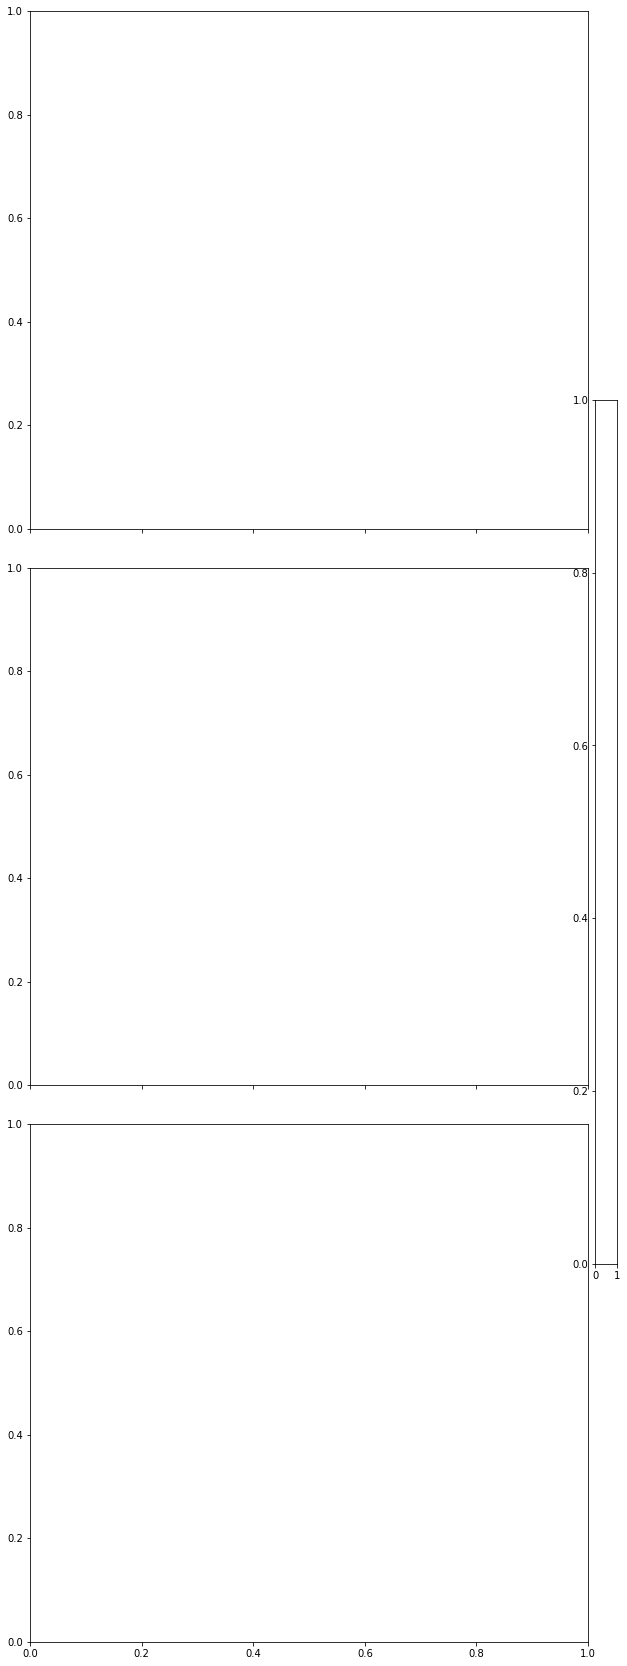

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10, 30),
                         gridspec_kw={'wspace': 0.025, 'hspace': 0.075})

cbar_ax = fig.add_axes([.91, .3, .03, .4])
r = 0
for trial_type, df in pd_dict.items():
    g = sns.heatmap(df, ax=axes[r], vmin=-.5, vmax=1., square=True,
                    cbar=True, cbar_ax=cbar_ax)
    axes[r].set_title(trial_type)
    # iterate over rows
    r += 1
plt.tight_layout()

References
==========
.. bibliography:: ../references.bib
   :style: plain
   :labelprefix: notebook-
   :keyprefix: n-


